# Naive Bayes
We will be implementing the multivariate Bernoulli variant of Naive Bayes.

## Hyperparameter configuration
Following the assignment guidelines, we will be experimenting with three hyperparameters throughout the testing of the project; m (for the size of the vocabulary), n (for the n most common words in the training data), and k (for the k least common words in the training data), the last 2 of which will not be included in the vocabulary.


In [1]:
m = 2500
n = 200
k = 50

## Fetch data
Fetching the reviews, while taking into account the aforementioned m, n and k hyperparameters.

In [4]:
import tensorflow as tf
import numpy as np

# fetching the reviews
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

# make a dictionary out of the words provided according to the above conditions 
word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

# x_train and x_test will consist of strings that represent reviews, but limited to the dictionary provided
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [19]:
print(x_train_text.shape)
print(x_train.shape)

(25000,)
(25000, 2210)


## Vectorize data

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)

# transforming the train and test text reviews into binary matrices
x_train_binary = binary_vectorizer.fit_transform(x_train_text)
x_test_binary = binary_vectorizer.transform(x_test_text)

x_train = np.array(x_train_binary.toarray())
x_test = np.array(x_test_binary.toarray())

## Information Gain

In [6]:
import math

def information_gain(class_, feature):
    classes = set(class_)

    hc = 0
    for c in classes:
        pc = list(class_).count(c)/len(class_)
        hc += - pc * math.log(pc, 2)
    print('Overall Entropy:', hc)
    feature_values = set(feature)

    hc_feature = 0
    for feat in feature_values:

        #pf --> P(X=x)
        pf = list(feature).count(feat)/len(feature)
        indices = [i for i in range(len(feature)) if feature[i] == feat]
        classes_of_feat = [class_[i] for i in indices]
        for c in classes:
            #pcf --> P(C=c|X=x)
            pcf = classes_of_feat.count(c)/len(classes_of_feat)
            if pcf != 0:
                # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                temp_h = - pf * pcf * math.log(pcf, 2)
                #sum for all values of C (class) and X (values of specific feature)
                hc_feature += temp_h
    ig = hc - hc_feature
    return ig

## Bernoulli Naive Bayes
We will be implementing the multivariate Bernoulli variant of Naive Bayes.

In [54]:
class CustomBernoulliNaiveBayes:
    def __init__(self):
        self.apriori_positive = None
        self.apriori_negative = None
        self.positive_category_feature_exists = None
        self.negative_category_feature_exists = None
    
    def fit(self, x, y, alpha = 1):
        """
        Fit the Bernoulli Naive Bayes model on the training data.

        :param x: The training data (2D array of shape (dataset size, number of features))
        :param y: The corresponding actual classification for each review (1D array of shape (number of data))
        :param alpha: optional (default=1)
            The parameter used for Laplace smoothing.
        :return: self - 
            The fitted class CustomBernoulliNaiveBayes instance (to allow for method chaining).
        """

        """
        apriori_positive: P(C=1). Set to the total number of positive reviews / the total number of reviews from our training data
        apriori_negative: P(C=0). Set to the total number of negative reviews / the total number of reviews from our training data
        """        
        self.apriori_positive = len(np.where(y == 1)[0]) / len(y)
        self.apriori_negative = len(np.where(y == 0)[0]) / len(y)

        """
        positive_category_feature_exists/negative_category_feature_exists are two arrays of size equal to the total amount
        of features (words in the vocabulary). Each index represents the (smoothed) probability the category will be
        positive or negative respectively, given that the feature in that specific index is present in the training data.
        In other words, for the m features present, the item on the i-th index of positive_category_feature_exists represents
        the probability of p(Xi = xi | C = 1) for the i-th feature, and likewise p(Xi = xi | C = 0) for the negative category. 
        """        
        self.positive_category_feature_exists = (np.sum(x[y == 1], axis=0) + alpha) / (len(np.where(y == 1)[0]) + 2 * alpha)
        self.negative_category_feature_exists = (np.sum(x[y == 0], axis=0) + alpha) / (len(np.where(y == 0)[0]) + 2 * alpha)
        
        return self
    
    def predict(self, x):
        """
        Predict the classifications for the given test data.

        :param x: The test data (2D array of shape (dataset size, number of features))
        :return: The predictions according to the model (1D array of shape (dataset size))
        """
        
        num_test_data = x.shape[0]

        # making 2 num_test_data sized arrays consisting of the apriori positive/negative probabilities (to optimise the multiplication that follows)
        positive_probs = np.full(num_test_data, self.apriori_positive)
        negative_probs = np.full(num_test_data, self.apriori_negative)

        """
        for each test sample, we multiply the apriori probabilities with feature-specific probabilities,
        considering feature presence (positive/negative_category_feature_exists) or absence (complement
        probabilities). Probabilities are filtered through exponentiation: x for feature presence, 1-x
        for absence (since x==1 means the feature is present, and x==0 means the feature is absent).
        """
        positive_probs *= np.prod(self.positive_category_feature_exists ** x * (1 - self.positive_category_feature_exists) ** (1 - x), axis=1)
        negative_probs *= np.prod(self.negative_category_feature_exists ** x * (1 - self.negative_category_feature_exists) ** (1 - x), axis=1)

        # for each test sample, choose the class with the higher probability for the final prediction
        predictions = np.where(positive_probs > negative_probs, 1, 0)

        return predictions

## Model Evaluation and Visualisation Functions
Helper functions for metric evaluations, as well as visual representation of the findings.

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def evaluate_metrics(estimator, x_train, y_train, x_test, y_test, splits=5):
    """
    Calculates accuracy, precision, recall, and f1-score for the amount of splits given.
    :param estimator: The estimator that will be evaluated.
    :param x_train: The numpy array of binary train data.
    :param y_train: The corresponding actual positive or negative classifications for x_train.
    :param x_test: The numpy array of binary test data.
    :param y_test: The corresponding actual positive or negative classifications for x_test.
    :param splits: The number of splits by which to divide the data.
    :return: A dictionary containing evaluation metrics for both train and test datasets.
    """

    if x_train.shape[0] != y_train.shape[0]:
        raise ValueError("The number of data points in x_train and y_train must be the same. "
                         f"Found {x_train.shape[0]} data points in x, but {y_train.shape[0]} data points in y.")
    elif x_test.shape[0] != y_test.shape[0]:
        raise ValueError("The number of data points in x_test and y_test must be the same. "
                         f"Found {x_test.shape[0]} data points in x, but {y_test.shape[0]} data points in y.")

    # x_splits/y_splits: Numpy arrays of size equal to splits; each index contains the data of the corresponding split
    x_splits = np.array_split(x_train, splits, axis=0)
    y_splits = np.array_split(y_train, splits, axis=0)
    
    # test_predictions: Will contain the predictions for test data.
    test_predictions = None
    
    # curr_x_split/curr_y_split: Initialised to none, will be updated throughout the loop following.
    curr_x_split = None
    curr_y_split = None

    # split_sizes: Since we opted for np.array_split instead of np.split, keeping track of the exact size of each split.
    split_sizes = np.array([])
    
    # train/test metric scores: Initialising empty arrays, which will keep track of the metrics we are tracking as the training data increases.
    train_accuracy_scores = np.array([])
    test_accuracy_scores = np.array([])
    train_precision_scores = np.array([])
    test_precision_scores = np.array([])
    train_recall_scores = np.array([])
    test_recall_scores = np.array([])
    train_f1_scores = np.array([])
    test_f1_scores = np.array([])

    for i in tqdm(range(splits)):
        curr_x_split = x_splits[i] if curr_x_split is None else np.concatenate((curr_x_split, x_splits[i]), axis=0)
        curr_y_split = y_splits[i] if curr_y_split is None else np.concatenate((curr_y_split, y_splits[i]), axis=0)

        # record the actual size of the current split
        split_sizes = np.append(split_sizes, curr_x_split.shape[0])

        # train the estimator on the current train data subset
        estimator.fit(curr_x_split, curr_y_split)

        # get the predictions for x as it has been determined up until this point
        train_predictions = estimator.predict(curr_x_split)
        test_predictions = estimator.predict(x_test)

        """
        For the train data, checking estimator's accuracy against the currently examined train data subset.
        For the test data, checking the estimator's accuracy against the entire test data.
        """
        train_accuracy_scores = np.append(train_accuracy_scores, accuracy_score(curr_y_split, train_predictions))
        test_accuracy_scores = np.append(test_accuracy_scores, accuracy_score(y_test, test_predictions))

        train_precision_scores = np.append(train_precision_scores, precision_score(curr_y_split, train_predictions))
        test_precision_scores = np.append(test_precision_scores, precision_score(y_test, test_predictions))

        train_recall_scores = np.append(train_recall_scores, recall_score(curr_y_split, train_predictions))
        test_recall_scores = np.append(test_recall_scores, recall_score(y_test, test_predictions))

        train_f1_scores = np.append(train_f1_scores, f1_score(curr_y_split, train_predictions))
        test_f1_scores = np.append(test_f1_scores, f1_score(y_test, test_predictions))

    # Creating a dictionary with descriptive keys to be returned.
    results_dict = {
        'Predictions': test_predictions,
        'Splits': splits,
        'Split Sizes': split_sizes,
        'Train Accuracy': train_accuracy_scores,
        'Test Accuracy': test_accuracy_scores,
        'Train Precision': train_precision_scores,
        'Test Precision': test_precision_scores,
        'Train Recall': train_recall_scores,
        'Test Recall': test_recall_scores,
        'Train F1': train_f1_scores,
        'Test F1': test_f1_scores       
    }

    return results_dict

def brief_summary(model_predictions, y_test, model_name = CustomBernoulliNaiveBayes.__name__):
    """
    Displays a brief summary of the model's classification performance, through a classification report and a confusion matrix heatmap.

    :param model_predictions: The model's predictions.
    :param y_test: The actual classifications (positive/negative).
    :param model_name: The name of the model for which to display the brief summary.
    """

    # printing the classification report for the estimator's final predictions
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, model_predictions))

    # showcasing the confusion matrix
    conf_matrix = confusion_matrix(y_test, model_predictions)
    plt.figure(figsize=(4, 4))
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True)
    heatmap.set_xticklabels(["Negative", "Positive"])
    heatmap.set_yticklabels(["Negative", "Positive"])
    heatmap.set(title=f"{model_name} Confusion Matrix Heatmap", xlabel="Predicted", ylabel="Actual")
    plt.show()
    
def create_metric_table(evaluation_dictionary, model_name = CustomBernoulliNaiveBayes.__name__):
    """
    Creates a table for the metrics for the model, as calculated by evaluate_metrics.
    :param evaluation_dictionary: The dictionary object returned by evaluate_metrics.
    :param model_name: The name of the model used for the metric calculations.
    """
    
    # going to use the percentage of data used per split as the dataframe index
    percentage_data_used = (evaluation_dictionary['Split Sizes'] / evaluation_dictionary['Split Sizes'][-1]) * 100

    metric_table = pd.DataFrame({
        'Train Data Used (%)': percentage_data_used,
        'Accuracy (Train)': evaluation_dictionary['Train Accuracy'].round(3),
        'Accuracy (Test)': evaluation_dictionary['Test Accuracy'].round(3),
        'Precision (Train)': evaluation_dictionary['Train Precision'].round(3),
        'Precision (Test)': evaluation_dictionary['Test Precision'].round(3),
        'Recall (Train)': evaluation_dictionary['Train Recall'].round(3),
        'Recall (Test)': evaluation_dictionary['Test Recall'].round(3),
        'F1 (Train)': evaluation_dictionary['Train F1'].round(3),
        'F1 (Test)': evaluation_dictionary['Test F1'].round(3)
    })

    metric_table.set_index('Train Data Used (%)', inplace=True)
    display(metric_table)    

def plot_learning_curve(metric_name, train_scores, test_scores, split_sizes):
    """
    Plot the learning curve for a specific metric.
    :param metric_name: The name of the metric (e.g., 'Accuracy', 'Precision', 'Recall', 'F1').
    :param train_scores: Array of train metric scores for each split.
    :param test_scores: Array of test metric scores for each split.
    :param split_sizes: Array of split sizes for each split.
    """

    plt.figure(figsize=(11, 5))

    # Plot with y-axis in the range [0, 1]
    plt.subplot(1, 2, 1)
    plt.plot(split_sizes, train_scores, marker='o', label='Train')
    plt.plot(split_sizes, test_scores, marker='o', label='Test')
    plt.xticks(split_sizes)
    plt.ylim(0, 1)
    plt.title(f'{metric_name} Learning Curve (Full Extent)')
    plt.xlabel('Training Data Used')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

    # Plot with y-axis limited to the range of values found in the metric scores
    plt.subplot(1, 2, 2)
    plt.plot(split_sizes, train_scores, marker='o', label='Train')
    plt.plot(split_sizes, test_scores, marker='o', label='Test')
    plt.xticks(split_sizes)
    plt.title(f'{metric_name} Learning Curve (Focused)')
    plt.xlabel('Training Data Used')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(estimator, x_train, y_train, x_test, y_test, splits = 5, model_name = CustomBernoulliNaiveBayes.__name__):
    """
    Executes metric_evaluation, brief_summary and plot_learning_curve in that order.
    :param estimator: The estimator that will be evaluated.
    :param x_train: The numpy array of binary train data.
    :param y_train: The corresponding actual positive or negative classifications for x_train.
    :param x_test: The numpy array of binary test data.
    :param y_test: The corresponding actual positive or negative classifications for x_test.
    :param splits: The number of splits by which to divide the data while evaluating metrics.
    :param model_name: The name of the model that will be evaluated.
    :return: A dictionary containing evaluation metrics for both train and test datasets. 
    """
    evaluation_results = evaluate_metrics(estimator, x_train, y_train, x_test, y_test, splits)
    brief_summary(evaluation_results['Predictions'], y_test)
    create_metric_table(evaluation_results)
    plot_learning_curve('Accuracy', evaluation_results['Train Accuracy'], evaluation_results['Test Accuracy'], evaluation_results['Split Sizes'])
    plot_learning_curve('Precision', evaluation_results['Train Precision'], evaluation_results['Test Precision'], evaluation_results['Split Sizes'])
    plot_learning_curve('Recall', evaluation_results['Train Recall'], evaluation_results['Test Recall'], evaluation_results['Split Sizes'])
    plot_learning_curve('F1', evaluation_results['Train F1'], evaluation_results['Test F1'], evaluation_results['Split Sizes'])
    
    return evaluation_results

def compare_models(model1_evaluations, model2_evaluations, model1_name, model2_name):
    return 
    

## Evaluating our model
We will be producing a classification report and a confusion matrix heatmap over the final predictions of the model, along with learning curves.

100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


CustomBernoulliNaiveBayes Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


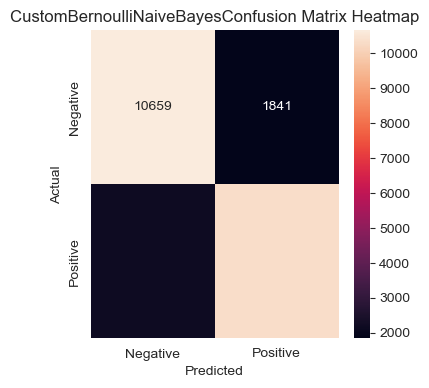

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.865,0.831,0.877,0.845,0.855,0.811,0.866,0.828
40.0,0.862,0.840,0.865,0.847,0.863,0.831,0.864,0.839
60.0,0.854,0.838,0.859,0.848,0.849,0.823,0.854,0.836
80.0,0.850,0.837,0.856,0.850,0.842,0.818,0.849,0.834
100.0,0.851,0.840,0.852,0.849,0.849,0.827,0.850,0.838


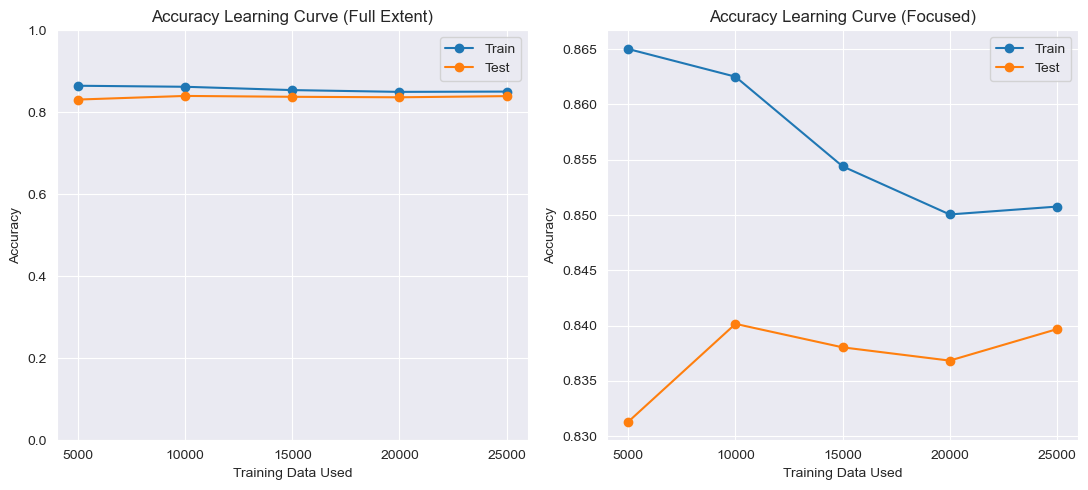

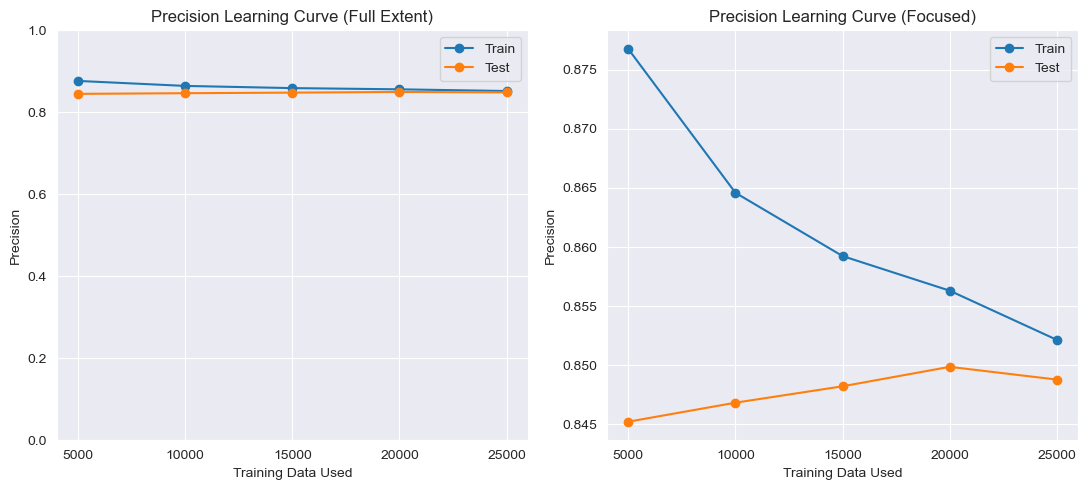

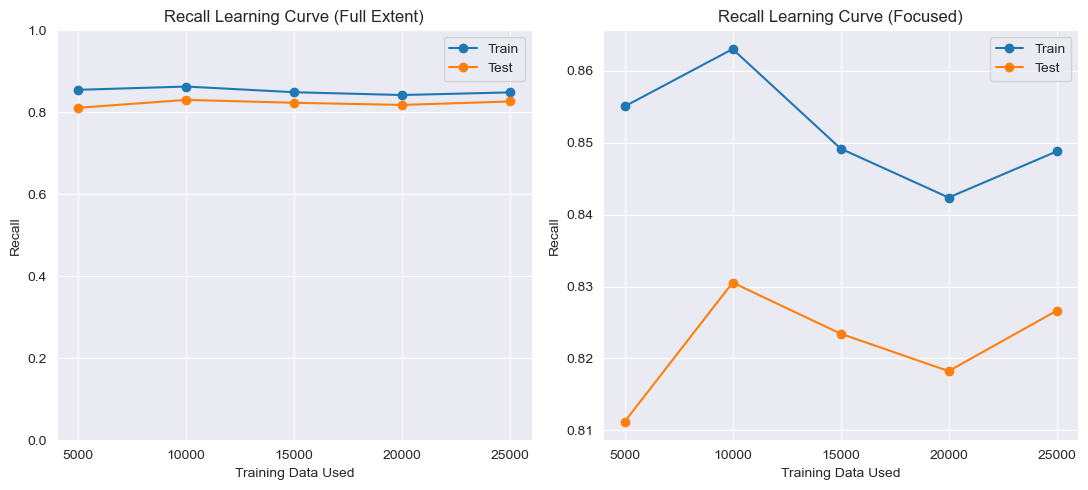

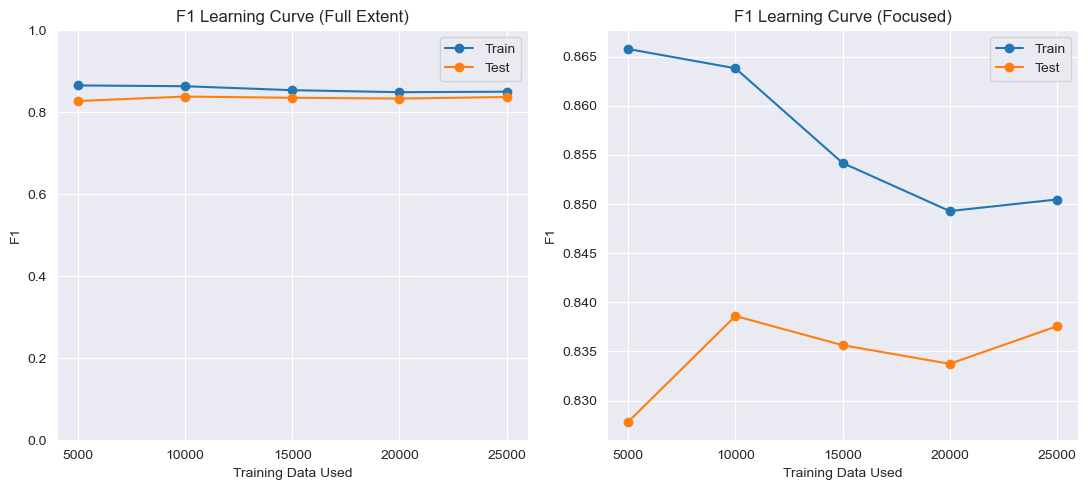

In [56]:
evaluation = evaluate_model(CustomBernoulliNaiveBayes(), x_train, y_train, x_test, y_test, 5)

## Comparing with Scikit-learn's Bernoulli Naive Bayes

100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


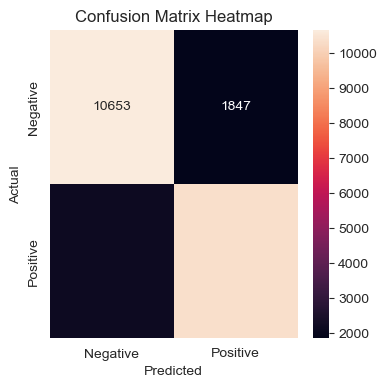

In [50]:
from sklearn.naive_bayes import BernoulliNB

sklearn_results = evaluate_metrics(BernoulliNB(), x_train, y_train, x_test, y_test)
brief_summary(sklearn_results['Predictions'], y_test)

In [52]:
create_metric_table(evaluation)
create_metric_table(sklearn_results)

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.865,0.831,0.877,0.845,0.855,0.811,0.866,0.828
40.0,0.862,0.840,0.865,0.847,0.863,0.831,0.864,0.839
60.0,0.854,0.838,0.859,0.848,0.849,0.823,0.854,0.836
80.0,0.850,0.837,0.856,0.850,0.842,0.818,0.849,0.834
100.0,0.851,0.840,0.852,0.849,0.849,0.827,0.850,0.838


,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.867,0.832,0.877,0.845,0.858,0.813,0.868,0.829
40.0,0.864,0.841,0.865,0.847,0.866,0.832,0.865,0.839
60.0,0.856,0.839,0.859,0.848,0.852,0.825,0.856,0.836
80.0,0.851,0.837,0.856,0.850,0.845,0.820,0.851,0.835
100.0,0.852,0.840,0.852,0.849,0.851,0.828,0.852,0.838
